# Como medir uma curva característica I-V

Link para um vídeo explicativo: https://youtu.be/f1jQmhs99-w

Em uma medição em ambiente real, não em simuladores, é praticamente impossível medir nas condições padrão de teste (STD), que seria: 1000 W/m², 25°C e 1,5 de Massa de Ar. Portanto, após a medição torna-se importante fazer a correção. Uma forma é transladar as curvas medidas para o STC. Conforme a norma IEC 60891 de 2009, vamos usar o procedimento 2, onde se utilizam 5 parâmetros semi-empíricos que podem ser obtidos com medições a diferentes temperaturas e irradiâncias, sendo esta a equação:

$I_2 = I_1.(1 + \alpha_{rel}.(T_2 - T_1)).\frac{G_2}{G_1}$

$V_2 = V_1 + V_{OC1}.(\beta_{rel}.(T_2 - T_1)+ a.ln(\frac{G_2}{G_1})) - R_s.(I_2-I_1) - \kappa.I_2.(T_2 - T_1)$

sendo:

$I_1$ e $V_1$ são as correntes e tensões medidas;

$I_2$ e $V_2$ são as correntes e tensões transladadas para as condições 2, no caso, STC;

$G_1$ e $T_1$ são a irradiância e temperatura na codição medida;

$G_2$ e $T_2$ são a irradiância e temperatura na condição desejada, no caso do STC: 1000 W/m² e 25°C;

$V_{OC1}$ é a tensão de circuito aberto na condição medida;

e os 5 parâmetros:

$\alpha_{rel}$ e $\beta_{rel}$ são os coeficientes de correção de temperatura a 1000 W/m², normalmente encontrado no datasheet do fabricante;

$a$, $R_s} e $\kappa$ são parâmetros utilizados para transladar e tem alguma relação com tensão térmica $V_d$ da junção PN, com a resistência série e um coeficiente de temperatura da resistência série, respectivamente.

## Medições de curvas IV sob (quase a) mesma temperatura

In [1]:
curvasIV = dlmread('curvasIV.csv',',');
Vm = curvasIV(:,1);
Im = curvasIV(:,2);
Tm = curvasIV(:,3);
Gm = curvasIV(:,4);

Plotando os dados de entrada

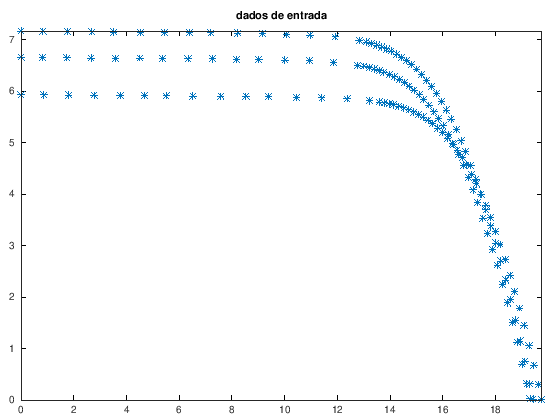

In [2]:
figure
plot(Vm,Im, '*')
xlim([0 max(Vm)])
ylim([0 max(Im)])
title('dados de entrada');

In [3]:
% Coeficientes Correção
alfa =   0.06020000/100; % [1/ºC] na Corrente
beta =  -0.35468047/100; % [1/ºC] na Tensão
a  = 0.0647002;
Rs = 0.2779663; % [Ohm]
%kappa = 0.0032334; % [V/A.ºC]

In [4]:
% STC
Gobj = 1000; % [W/m2]
Tobj = 25; % ºC

# Encontrar o Valor de kappa
segundo a Norma IEC 60891 de 2009

In [5]:
%% correcao para Ponto de Máxima potência
function val = max_P_diff_for_Rs(Im,Vm,Tm,Gm, Tobj, Gobj, alfa, beta, Rs, a,kappa)
    Itransl = Im .* (1 + alfa.*(Tobj - Tm)) .* Gobj ./ Gm;
    Vtransl = Vm + max(Vm).*(beta.*(Tobj - Tm) + a.*log(Gobj./Gm)) - Rs.*(Itransl - Im) - kappa.*Itransl.*(Tobj - Tm);
    for i=1:3 %4
        Pmp(i)     = max(Vtransl((1+56*(i-1)):56*i) .* Itransl((1+56*(i-1)):56*i));
    end
    val = max(abs((Pmp - median(Pmp))./median(Pmp)));
end

In [6]:
%% Determinacao de Kappa
%Rs = 0; a = 0;
kappa_objfun = @(kappa) max_P_diff_for_Rs(Im,Vm,Tm,Gm, Tobj, Gobj, alfa, beta, Rs, a, kappa);
options = optimset('TolX', 1e-6);
kappa = fminsearch(kappa_objfun, 0, options);
fprintf('kappa = %.7f\n', kappa);
erro_kappa = kappa_objfun(kappa);
fprintf('erro_kappa  = %.7f\n', erro_kappa);

kappa = 0.0038567
erro_kappa  = 0.0004988


In [7]:
% Transladar segundo a Norma
Itransl = Im .* (1 + alfa.*(Tobj - Tm)) .* Gobj ./ Gm;
Vtransl = Vm + max(Vm).*(beta.*(Tobj - Tm) + a.*log(Gobj./Gm)) - Rs.*(Itransl - Im) - kappa.*Itransl.*(Tobj - Tm);

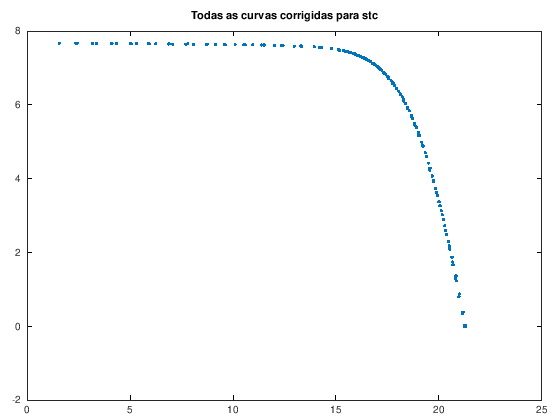

In [8]:
figure
plot(Vtransl,Itransl, '.')
title('Todas as curvas corrigidas para stc')